In [1]:
!pip install chess

  Using cached chess-1.4.0-py3-none-any.whl (141 kB)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import chess.pgn

In [4]:
pgn = open("games.pgn")

In [5]:
l = []
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    l.append(game)

In [6]:
rated = [x for x in l if 'Casual' not in x.headers['Event']]

In [7]:
game_lengths = pd.read_csv('Game_Lengths.csv')

In [8]:
tmp = game_lengths.head(10)
tmp = tmp.drop([5])

In [9]:
gl = game_lengths.Game.reindex(range(2309), fill_value=0)

In [10]:
all_game_data = pd.DataFrame({"White":[game.headers['White'] for game in rated],
                              "Black":[game.headers['Black'] for game in rated],
                              "WhiteElo":[game.headers['WhiteElo'] for game in rated],
                              "BlackElo":[game.headers['BlackElo'] for game in rated],
                              "Result":[game.headers['Result'] for game in rated],
                              "Time Control":[game.headers['TimeControl'] for game in rated],
                              "Date":[game.headers['Date'] for game in rated],
                              "WhiteRatingDiff":[game.headers['WhiteRatingDiff'] for game in rated],
                              "BlackRatingDiff":[game.headers['BlackRatingDiff'] for game in rated],
                              "Termination":[game.headers['Termination'] for game in rated],
                              "Game Length":gl.values})

In [11]:
all_game_data.head()

,White,Black,WhiteElo,BlackElo,Result,Time Control,Date,WhiteRatingDiff,BlackRatingDiff,Termination,Game Length
0,jowen93,misappp,1570,1608,0-1,120+1,2021.01.10,-6,+5,Normal,26
1,stockfishing,jowen93,1606,1563,0-1,120+1,2021.01.08,-6,+7,Normal,25
2,Sapog_62,jowen93,1572,1562,1/2-1/2,120+1,2021.01.08,+0,+1,Normal,59
3,jowen93,Octaviorl888,1568,1636,0-1,120+1,2021.01.08,-6,+6,Time forfeit,28
4,farmer1962rt,jowen93,1571,1561,0-1,120+1,2021.01.07,-6,+7,Time forfeit,28


In [12]:
normal = all_game_data.loc[all_game_data['Termination'] == "Normal"]
forfeit = all_game_data.loc[all_game_data['Termination'] == "Time forfeit"]

In [13]:
print(forfeit['Game Length'].mean())
print(forfeit['Game Length'].std())
print(normal['Game Length'].mean())
print(normal['Game Length'].std())

36.37936046511628
14.733636319077194
35.82070707070707
15.22659094787546


In [57]:
def my_colour(username):
    if username == "jowen93":
        return "White"
    return "Black"
all_game_data['My Colour'] = all_game_data.White.apply(lambda x: my_colour(x))

In [58]:
all_game_data['My Rating'] = np.where(all_game_data['My Colour'] == "White",
                                      all_game_data['WhiteElo'],
                                      all_game_data['BlackElo'])

In [59]:
all_game_data['My Rating Change'] = np.where(all_game_data['My Colour'] == "White",
                                      all_game_data['WhiteRatingDiff'],
                                      all_game_data['BlackRatingDiff'])

In [60]:
all_game_data = all_game_data.loc[~(all_game_data['Time Control'] == '-')]

In [61]:
time_controls = all_game_data['Time Control'].unique()

In [62]:
readable_tc = ["Bullet" if i < 180 else "Blitz" if i<600 else "Rapid" for i in 
               [int(i.split('+')[0]) for i in time_controls]]

In [63]:
d = dict(zip(time_controls, readable_tc))

In [64]:
all_game_data['Type'] = all_game_data['Time Control'].apply(lambda x: d[x])

In [65]:
all_game_data['My Rating Change'] = all_game_data['My Rating Change'].astype('int')

In [66]:
all_game_data.head()

,White,Black,WhiteElo,BlackElo,Result,Time Control,Date,WhiteRatingDiff,BlackRatingDiff,Termination,Game Length,My Colour,My Rating,My Rating Change,Type
0,jowen93,misappp,1570,1608,0-1,120+1,2021.01.10,-6,+5,Normal,26,White,1570,-6,Bullet
1,stockfishing,jowen93,1606,1563,0-1,120+1,2021.01.08,-6,+7,Normal,25,Black,1563,7,Bullet
2,Sapog_62,jowen93,1572,1562,1/2-1/2,120+1,2021.01.08,+0,+1,Normal,59,Black,1562,1,Bullet
3,jowen93,Octaviorl888,1568,1636,0-1,120+1,2021.01.08,-6,+6,Time forfeit,28,White,1568,-6,Bullet
4,farmer1962rt,jowen93,1571,1561,0-1,120+1,2021.01.07,-6,+7,Time forfeit,28,Black,1561,7,Bullet


In [73]:
all_game_data['Opp. Rating'] = np.where(all_game_data['White'] == "jowen93",
                                        all_game_data['BlackElo'],
                                        all_game_data['WhiteElo'])

In [67]:
all_game_data.Date = pd.to_datetime(all_game_data.Date)

In [74]:
all_game_data = all_game_data.sort_values(by='Date')

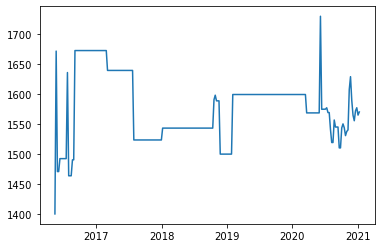

In [69]:
bullet = all_game_data.loc[all_game_data.Type == 'Bullet']
bullet = bullet.set_index('Date')
bullet['My Rating'] = bullet['My Rating'].astype('int')
bullet_ratings = bullet['My Rating'].resample('7D').mean().ffill()

plt.plot(bullet_ratings)

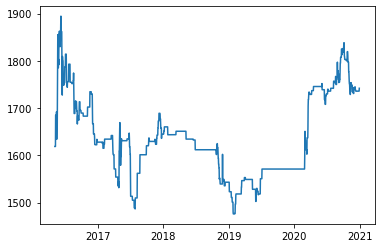

In [70]:
blitz = all_game_data.loc[all_game_data.Type == 'Blitz']
blitz = blitz.set_index('Date')
blitz['My Rating'] = blitz['My Rating'].astype('int')
blitz_ratings = blitz['My Rating'].resample('1D').mean().ffill()

plt.plot(blitz_ratings)

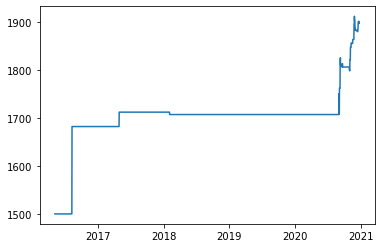

In [71]:
rapid = all_game_data.loc[all_game_data.Type == 'Rapid']
rapid = rapid.set_index('Date')
rapid['My Rating'] = rapid['My Rating'].astype('int')
rapid_ratings = rapid['My Rating'].resample('1D').mean().ffill()

plt.plot(rapid_ratings)

In [72]:
all_ratings = pd.DataFrame({'bullet': bullet_ratings, 'blitz': blitz_ratings, 'rapid':rapid_ratings}).ffill().bfill()

In [73]:
all_ratings = all_ratings.reset_index()

In [74]:
all_ratings.to_csv('all_ratings.csv')

In [76]:
all_game_data.to_csv('all_games.csv')

In [38]:
blitz_rating_change = all_game_data.loc[all_game_data['Type'] == "Blitz"][['Date', 'My Rating Change']].set_index('Date').resample('1D').mean().fillna(0)
bullet_rating_change = all_game_data.loc[all_game_data['Type'] == "Bullet"][['Date', 'My Rating Change']].set_index('Date').resample('1D').mean().fillna(0)
rapid_rating_change = all_game_data.loc[all_game_data['Type'] == "Rapid"][['Date', 'My Rating Change']].set_index('Date').resample('1D').mean().fillna(0)

In [75]:
all_game_data.head()

,White,Black,WhiteElo,BlackElo,Result,Time Control,Date,WhiteRatingDiff,BlackRatingDiff,Termination,Game Length,My Colour,My Rating,My Rating Change,Type,Opp. Rating
2308,jowen93,moisessantos,1500,1612,1-0,180+5,2016-05-08,+243,-9,Normal,0,White,1500,243,Blitz,1612
2304,jowen93,LifesaQueen,1661,1660,1/2-1/2,180+0,2016-05-08,+0,+0,Time forfeit,0,White,1661,0,Blitz,1660
2307,moisessantos,jowen93,1603,1743,1-0,180+5,2016-05-08,+12,-172,Time forfeit,0,Black,1743,-172,Blitz,1603
2306,sergio-sj-arg,jowen93,1414,1500,0-1,600+0,2016-05-08,-6,+144,Normal,0,Black,1500,144,Rapid,1414
2305,tigerofches2,jowen93,1553,1571,0-1,180+0,2016-05-08,-9,+90,Time forfeit,0,Black,1571,90,Blitz,1553
